In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import Divider, Size

In [2]:
from typing import Callable

# Cinemática inversa

O objeto de estudo na cinemática inversa são os braços robóticos. A saída desse sistema será a posição do braço no espaço. Na cinemátida direta, a entrada do sistema são os ângulos das juntas robóticas.

Dessa forma, cabe ao responsável pelo input realizar cálculos para descobrir os ângulos referentes às posições desejadas.

Já na cinemática inversa, o input é a posição desejada. Com isso, o sistema deve encontrar os ângulos referentes de forma numérica.

# Cinemática inversa numérica

Sendo $x=f(\theta)$ o vetor das posições referentes aos ângulos ($\theta\in\mathbb{R}^n$), e $x_d \in\mathbb{R}^m$ as coordenadas desejadas, a solução será $\theta_d$ tal que $g(\theta_d)=x_d-f(\theta_d)=0$.

Pelo método de Newton-Raphson, para resolver uma equação do tipo $g(\theta)=0$ , se usa a expansão de Taylor de primeira ordem:

$g(\theta)=g(\theta_0)+\frac{\partial g}{\partial\theta}\Big|_{\theta_0}(\theta-\theta_0)~~$
$\overset{g(\theta)=0}{\longrightarrow}~~$
$\theta=\theta_0-\Big(\frac{\partial g}{\partial\theta}\Big|_{\theta_0}\Big)^{-1}g(\theta_0)$

Generalizando:

$\theta_{k+1}=\theta_k-\Big(\frac{\partial g}{\partial\theta}\Big|_{\theta_k}\Big)^{-1}g(\theta_k)$

Com isso:

$x_d=f(\theta_d)=f(\theta_0)+\underset{J(\theta_0)}{\boxed{\frac{\partial f}{\partial\theta}\Big|_{\theta_0}}}
\cdot\underset{\Delta\theta}{\boxed{(\theta_d-\theta_0)}}~,~~J(\theta_0)\in\mathbb{R}^{m\times n}~\Rightarrow~$
$J(\theta_0)\Delta\theta=x_d-f(\theta_0)~\Rightarrow$

$\theta_1=\theta_0+\Delta\theta$

Generalizando:

$\theta_{k+1}=\theta_k+\Delta\theta_k$

**Obs:** Sendo $f(\theta) = \big[f_1(\theta)~,~~f_2(\theta)~,~~\cdots~,~~f_n(\theta)\big]$:

$J(\theta)=$
$\begin{bmatrix}
\frac{\partial f_1}{\partial\theta_1}(\theta)&\cdots&\frac{\partial f_1}{\partial\theta_n}(\theta)\\
\vdots&\ddots&\vdots\\
\frac{\partial f_n}{\partial\theta_1}(\theta)&\cdots&\frac{\partial f_n}{\partial\theta_n}(\theta)
\end{bmatrix}$

## Caso para 1 dimensão

O caso para 1 dimensão se resume em encontrar um ângulo referente a uma posição em um círculo. Pode-se usar o método de Newton.

![Um grau de liberdade](img/1d.jpeg)

### Método de Newton

In [3]:
def nr(f: Callable[[float], float], df: Callable[[float], float], x: float, p: float) -> float:
    # p = chute inicial
    def g(w):
        return f(w) - x
    xl = p
    # critérios de parada
    N, e_stop = 50, 1e-8
    iter, e = 0, 1
    while iter < N-1 and e > e_stop:
        xn = xl - g(xl)/df(xl)
        e = xn
        xl = xn
        iter += 1

    return xn

In [4]:
R = 3

def f_1d(theta: float) -> float:
    return theta*R

def d_f_1d(theta: float) -> float:
    return R

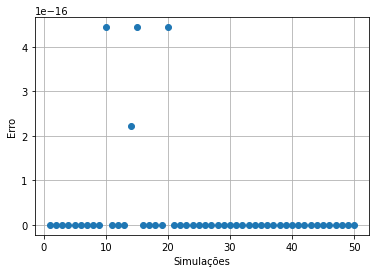

In [5]:
l = []
for i in range(50):
    xd = np.random.uniform(0, 5, [1, 2])[0][0]
    try:
        theta_nr = nr(f_1d, d_f_1d, xd, 0.7)
        x = f_1d(theta_nr)
        #print(f"x desejado: {xd}  x encontrado: {x} Erro: {np.sqrt(abs(xd - x)**2)}")
        l.append(np.sqrt(abs(xd - x)**2))
    except (ValueError, np.linalg.LinAlgError) as e:
        pass
plt.plot([i+1 for i in range(50)],l, 'o')
plt.ylabel('Erro')
plt.xlabel('Simulações')
plt.grid()

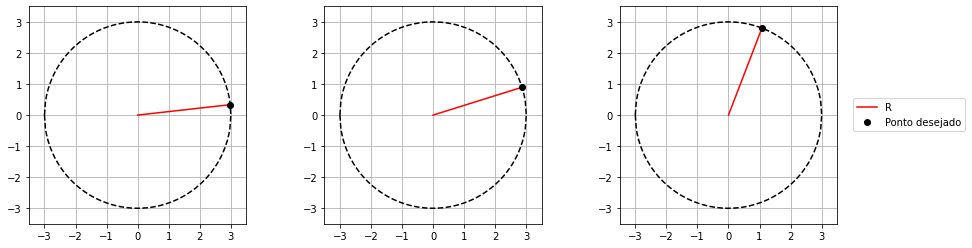

In [6]:
x_simul = []
while(len(x_simul)<3):
    try:
        xd = np.random.uniform(0, 5, [1, 2])[0][0]
        theta_nr = nr(f_1d, d_f_1d, xd, 0.7)
        x = f_1d(theta_nr)
        x_simul.append((xd, x))
    except:
        pass
fig, axs = plt.subplots(ncols=3, figsize=(15,4), sharey=False)
for i, simul in enumerate(x_simul):
    xs = np.linspace(-R, R, num=200)
    axs[i].plot(xs, np.sqrt(R**2-xs**2), color="black", linestyle="--")
    axs[i].plot(xs, -np.sqrt(R**2-xs**2), color="black", linestyle="--")
    xd = [R*np.cos(simul[0]/R), R*np.sin(simul[0]/R)]
    x = [R*np.cos(simul[1]/R), R*np.sin(simul[1]/R)]
    axs[i].plot([0, x[0]], [0, x[1]], color="red", label="R")
    axs[i].plot(*xd, 'o', color='black', label='Ponto desejado')
    axs[i].set_xlim(-3.5, 3.5)
    axs[i].set_ylim(-3.5, 3.5)
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].grid()

axs[2].legend(bbox_to_anchor = (1.05, 0.6));

## Caso para 2 dimensões

![Dois graus de liberdade](img/2d.jpeg)

$f=\Big(f_1(\theta_1,\theta_2),~f_2(\theta_1,\theta_2)\Big)=\Big(R_1\cos(\theta_1)+R_2\cos(\theta_2),~R_1\sin(\theta_1)+R_2\sin(\theta_2)\Big)$

$J=\begin{bmatrix}\frac{\partial f_1}{\partial\theta_1}&\frac{\partial f_1}{\partial\theta_2}\\\frac{\partial f_2}{\partial\theta_1}&\frac{\partial f_2}{\partial\theta_2}\end{bmatrix}=$
$\begin{bmatrix}-R_1\sin(\theta_1)&-R_2\sin(\theta_2)\\R_1\cos(\theta_1)&R_2\cos(\theta_2)\end{bmatrix}$

**Newton-Raphson:**

$\begin{bmatrix}
-R_1\sin(\theta_{1_k})&-R_2\sin(\theta_{2_k})\\
R_1\cos(\theta_{1_k})&R_2\cos(\theta_{2_k})
\end{bmatrix}$
$\begin{bmatrix}
\theta_{1_{k+1}}-\theta_{1_k}\\
\theta_{2_{k+1}}-\theta_{2_k}\\
\end{bmatrix}=$
$\begin{bmatrix}
x_{1_d}\\x_{2_d}
\end{bmatrix}-$
$\begin{bmatrix}
R_1\cos(\theta_{1_k})+R_2\cos(\theta_{2_k})\\
R_1\sin(\theta_{1_k})+R_2\sin(\theta_{2_k})
\end{bmatrix}$

$\begin{bmatrix}
\theta_{1_{k+1}}-\theta_{1_k}\\
\theta_{2_{k+1}}-\theta_{2_k}
\end{bmatrix}=
\begin{bmatrix}
-R_1\sin(\theta_{1_k})&-R_2\sin(\theta_{2_k})\\
R_1\cos(\theta_{1_k})&R_2\cos(\theta_{2_k})
\end{bmatrix}^{-1}
\begin{bmatrix}
x_{1_d} - \big(R_1\cos(\theta_{1_k})+R_2\cos(\theta_{2_k})\big)\\
x_{2_d} - \big(R_1\sin(\theta_{1_k})+R_2\sin(\theta_{2_k})\big)
\end{bmatrix}$

$\Theta = A^{-1}\cdot\Big[X-B\Big]$

In [7]:
def A_matrix_maker(R1, R2, theta1, theta2):
    return [[-R1*np.sin(theta1), -R2*np.sin(theta2)], [R1*np.cos(theta1), R2*np.cos(theta2)]]
def B_matrix_maker(R1, R2, theta1, theta2):
    return [R1*np.cos(theta1)+R2*np.cos(theta2), R1*np.sin(theta1)+R2*np.sin(theta2)]

In [8]:
def nr_2d(R1: float, R2: float, theta1: float, theta2: float, xd: list) -> tuple:
    xd = np.asarray(xd)
    mod = np.sqrt(xd[0]**2 + xd[1]**2)
    if mod > R1+R2 or mod < abs(R1-R2):
        raise ValueError("Não alcançável")
    loop = True
    iter = 0
    while loop:
        iter += 1
        A_matrix = np.asarray(A_matrix_maker(R1, R2, theta1, theta2))
        B_matrix = np.asarray(B_matrix_maker(R1, R2, theta1, theta2))
        Theta_vector = np.matmul(np.linalg.inv(A_matrix), xd - B_matrix)
        theta1, theta2 = Theta_vector[0] + theta1, Theta_vector[1] + theta2
        x = np.asarray(B_matrix_maker(R1, R2, theta1, theta2))
        loop = iter < 50 and not np.allclose(xd, x, rtol=1e-10)
    return theta1, theta2, x

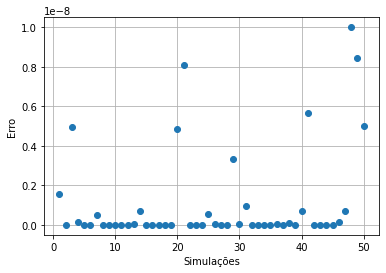

In [9]:
theta1, theta2 = (-np.pi/4, np.pi/4)
R1, R2 = 3, 2.5
l = []

while(len(l)<50):
    xd = np.random.uniform(1, 5, [1, 2])[0]
    try:
        _, _, x = nr_2d(R1, R2, theta1, theta2, xd)
        #print(f"x desejado: {xd}  x encontrado: {x} Erro: {sum(np.sqrt(abs(xd - x)**2))}")
        l.append(sum(np.sqrt(abs(xd - x)**2)))
    except (ValueError, np.linalg.LinAlgError) as e:
        pass
plt.plot([i+1 for i in range(50)], l, 'o')
plt.ylabel('Erro')
plt.xlabel('Simulações')
plt.grid()

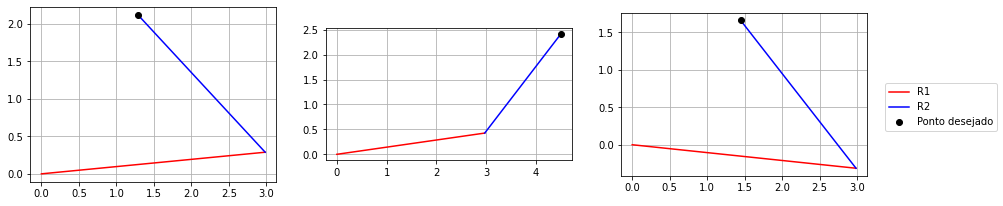

In [10]:
x_simul=[]
while(len(x_simul)<3):
    try:
        xd = np.random.uniform(1, 5, [1, 2])[0]
        theta1, theta2, x = nr_2d(R1, R2, theta1, theta2, xd)
        coord1 = np.asarray([R1*np.cos(theta1), R1*np.sin(theta1)])
        x_simul.append((xd, x, coord1))
    except:
        pass

fig, axs = plt.subplots(ncols=3, figsize=(15,4), sharey=False)
for i, simul in enumerate(x_simul):
    axs[i].plot([0, simul[2][0]], [0, simul[2][1]], '-', color='red', label='R1')
    axs[i].plot([simul[2][0], simul[1][0]], [simul[2][1], simul[1][1]], '-', color='blue', label='R2')
    axs[i].plot(*simul[0], 'o', color='black', label='Ponto desejado')
    axs[i].set_aspect('equal', adjustable='box')
    axs[i].grid()
axs[2].legend(bbox_to_anchor = (1.05, 0.6));

## Caso para 3 dimensões

![Três graus de liberdade](img/3d.jpeg)

$f=\Big(f_1(\theta_1,\theta_2,\theta_3),~f_2(\theta_1,\theta_2,\theta_3),~f_3(\theta_1,\theta_2,\theta_3)\Big)=\Big(\big[R1\cos\theta_1+R_2\cos\theta_2\big]\sin\theta_3,~\big[R1\cos\theta_1+R_2\cos\theta_2\big]\cos\theta_3,~R1\sin\theta_1+R_2\sin\theta_2\Big)$

$J=\begin{bmatrix}\frac{\partial f_1}{\partial\theta_1}&\frac{\partial f_1}{\partial\theta_2}&\frac{\partial f_1}{\partial\theta_3}\\\frac{\partial f_2}{\partial\theta_1}&\frac{\partial f_2}{\partial\theta_2}&\frac{\partial f_2}{\partial\theta_3}\\\frac{\partial f_3}{\partial\theta_1}&\frac{\partial f_3}{\partial\theta_2}&\frac{\partial f_3}{\partial\theta_1}\end{bmatrix}=$
$\begin{bmatrix}-R1\sin\theta_1\sin\theta_3&-R2\sin\theta_2\sin\theta_3&\big[R1\cos\theta_1+R_2\cos\theta_2\big]\cos\theta_3\\-R1\sin\theta_1\cos\theta_3&-R2\sin\theta_2\cos\theta_3&-\big[R1\cos\theta_1+R_2\cos\theta_2\big]\sin\theta_3\\R1\cos\theta_1&R2\cos\theta_2&0\end{bmatrix}$

**Newton-Raphson:**

$\begin{bmatrix}\theta_{1_{k+1}}-\theta_{1_{k}}\\\theta_{2_{k+1}}-\theta_2{_{k}}\\\theta_{3_{k+1}}-\theta_{3_{k}}\end{bmatrix}=$
$\begin{bmatrix}-R1\sin\theta_{1_{k}}\sin\theta_{3_{k}}&-R2\sin\theta_{2_{k}}\sin\theta_{3_{k}}&\big[R1\cos\theta_{1_{k}}+R_2\cos\theta_{2_{k}}\big]\cos\theta_{3_{k}}\\-R1\sin\theta_{1_{k}}\cos\theta_{3_{k}}&-R2\sin\theta_{2_{k}}\cos\theta_{3_{k}}&-\big[R1\cos\theta_{1_{k}}+R_2\cos\theta_{2_{k}}\big]\sin\theta_{3_{k}}\\R1\cos\theta_{1_{k}}&R2\cos\theta_{2_{k}}&0\end{bmatrix}^{-1}$
$\begin{bmatrix}x_{1_d}-\big[R1\cos\theta_{1_{k}}+R_2\cos\theta_{2_{k}}\big]\sin\theta_{3_{k}}\\x_{2_d}-\big[R1\cos\theta_{1_{k}}+R_2\cos\theta_{2_{k}}\big]\cos\theta_{3_{k}}\\x_{3_d}-R1\sin\theta_{1_{k}}+R_2\sin\theta_{2_{k}}\end{bmatrix}$

$\Theta_3 = A_3^{-1}\cdot\Big[X-B_3\Big]$

In [11]:
def A3_matrix_maker(R1, R2, theta1, theta2, theta3):
    return [
        [-R1*np.sin(theta1)*np.sin(theta3),
         -R2*np.sin(theta2)*np.sin(theta3),
         (R1*np.cos(theta1)+R2*np.cos(theta2))*np.cos(theta3)],
        [-R1*np.sin(theta1)*np.cos(theta3),
         -R2*np.sin(theta2)*np.cos(theta3),
         -(R1*np.cos(theta1)+R2*np.cos(theta2))*np.sin(theta3)],
        [R1*np.cos(theta1), R2*np.cos(theta2), 0]
    ]
def B3_matrix_maker(R1, R2, theta1, theta2, theta3):
    return [
        (R1*np.cos(theta1)+R2*np.cos(theta2))*np.sin(theta3),
        (R1*np.cos(theta1)+R2*np.cos(theta2))*np.cos(theta3),
        R1*np.sin(theta1)+R2*np.sin(theta2)
    ]

In [12]:
def nr_3d(R1: float, R2: float, theta1: float, theta2: float, theta3: float, xd: list) -> tuple:
    xd = np.asarray(xd)
    mod = np.sqrt(xd[0]**2 + xd[1]**2 + xd[2]**2)
    if mod > R1+R2 or mod < abs(R1-R2):
        raise ValueError("Não alcançável")
    loop = True
    iter = 0
    while loop:
        iter += 1
        A_matrix = np.asarray(A3_matrix_maker(R1, R2, theta1, theta2, theta3))
        B_matrix = np.asarray(B3_matrix_maker(R1, R2, theta1, theta2, theta3))
        Theta_vector = np.matmul(np.linalg.inv(A_matrix), xd - B_matrix)
        theta1, theta2, theta3 = Theta_vector[0] + theta1, Theta_vector[1] + theta2, Theta_vector[2] + theta3
        x = np.asarray(B3_matrix_maker(R1, R2, theta1, theta2, theta3))
        loop = iter < 50 and not np.allclose(xd, x, rtol=1e-10)
    return theta1, theta2, theta3, x

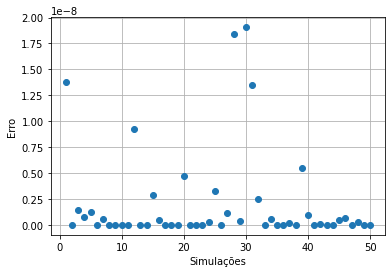

In [13]:
theta1, theta2, theta3 = (-np.pi/4, np.pi/4, np.pi/4)
R1, R2 = 3, 2.5
l = []
while(len(l)<50):
    xd = np.random.uniform(1, 4.5, [1, 3])[0]
    try:
        _, _, _, x = nr_3d(R1, R2, theta1, theta2, theta3, xd)
        #print(f"x desejado: {xd}  x encontrado: {x} Erro: {sum(np.sqrt(abs(xd - x)**2))}")
        l.append(sum(np.sqrt(abs(xd - x)**2)))
    except (ValueError, np.linalg.LinAlgError) as e:
        pass
plt.plot([i+1 for i in range(50)], l, 'o')
plt.ylabel('Erro')
plt.xlabel('Simulações')
plt.grid()

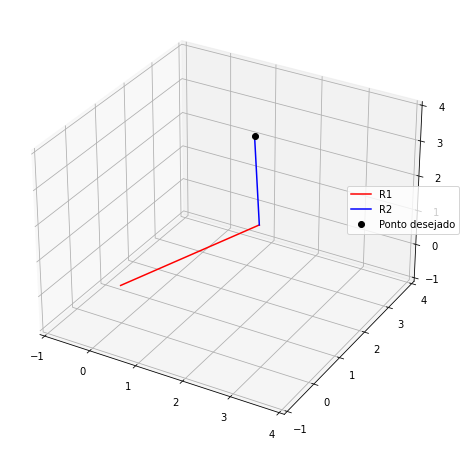

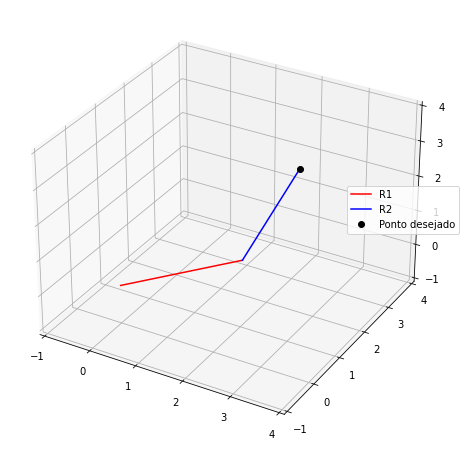

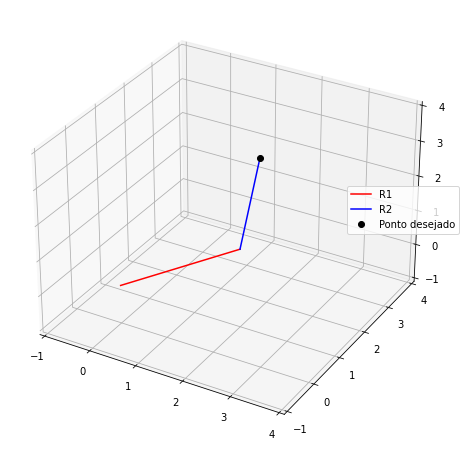

In [14]:
x_simul = []
while(len(x_simul)<3):
    try:
        xd = np.random.uniform(1, 4.5, [1, 3])[0]
        theta1, theta2, theta3, x = nr_3d(R1, R2, theta1, theta2, theta3, xd)
        coord1 = np.asarray([R1*np.cos(theta1)*np.sin(theta3), R1*np.cos(theta1)*np.cos(theta3), R1*np.sin(theta1)])
        x_simul.append((xd, x, coord1))
    except:
        pass

axs = [None]*3
for i, simul in enumerate(x_simul):
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    axs[i] = plt.axes(projection='3d')
    axs[i].plot([0, simul[2][0]], [0, simul[2][1]], [0, simul[2][2]], color='red', label='R1')
    axs[i].plot([simul[2][0], simul[1][0]], [simul[2][1], simul[1][1]], [simul[2][2], simul[1][2]], color='blue', label='R2')
    axs[i].plot(*simul[0], 'o', color='black', label='Ponto desejado')
    axs[i].set_xlim3d(-1, 4)
    axs[i].set_ylim3d(-1, 4)
    axs[i].set_zlim3d(-1, 4)
    axs[i].legend(bbox_to_anchor = (1.05, 0.6))